In [1]:
# Trading Chart Classification with ResNet50 - Baseline Model
# Based on baseline.py with Kaggle dataset integration
!pip install timm torch torchvision tqdm pandas pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.

In [2]:
import argparse
import os
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ----------------- CONFIG -----------------
MODEL_DIR = "models"  # Will be created in Kaggle working directory
LABELS_CSV = "/kaggle/input/labels.csv"
IMAGES_ROOT = "/kaggle/input/SBER_images(2025-06-01 - 2025-10-01)"

# Memory-optimized hyperparameters
BATCH_SIZE = 4  # Much smaller batch size
GRADIENT_ACCUMULATION_STEPS = 8  # Accumulate gradients over multiple batches
NUM_EPOCHS = 30
LEARNING_RATE_BACKBONE = 1e-4  # More conservative than your 5e-4
LEARNING_RATE_CLASSIFIER = 3e-4  # Less aggressive than your 1e-3
WEIGHT_DECAY = 1e-4  # Lighter than your 5e-4
VAL_FRAC = 0.2
SEED = 42
NUM_WORKERS = 2  # Reduced workers to save memory

In [4]:
# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')
if DEVICE.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

Device: cuda
GPU: Tesla T4
Memory: 14.7 GB


In [5]:
# Dataset class from baseline.py
class CVImageDataset(Dataset):
    def __init__(self, df, transform=None, to_rgb=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.to_rgb = to_rgb

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        p = self.df.loc[idx, 'path']
        img = Image.open(p)
        if self.to_rgb:
            img = img.convert('RGB')
        x = self.transform(img) if self.transform is not None else transforms.ToTensor()(img)
        y = int(self.df.loc[idx, 'label_idx'])
        return x, torch.tensor(y, dtype=torch.long)

In [6]:
def make_dataloaders(labels_csv=LABELS_CSV, images_root=IMAGES_ROOT, batch_size=BATCH_SIZE, 
                    subset=None, val_frac=VAL_FRAC, num_workers=NUM_WORKERS, seed=SEED):
    df = pd.read_csv(labels_csv)
    df['label'] = df['label'].astype(str).str.strip().str.lower()
    label_map = {lab: i for i, lab in enumerate(sorted(df['label'].unique()))}
    df['label_idx'] = df['label'].map(label_map)
    df['path'] = df['filename'].apply(lambda x: os.path.join(images_root, x))

    if subset is not None and subset > 0:
        df = df.sample(n=min(subset, len(df)), random_state=seed).reset_index(drop=True)

    # MISSING: Split the data into train and validation sets
    train_df, val_df = train_test_split(
        df, test_size=val_frac, stratify=df['label_idx'], 
        random_state=seed, shuffle=True
    )

    # Smart preprocessing for chart images - maintain aspect ratio and key features
    train_transform = transforms.Compose([
        transforms.Resize((512, 512)),  # Larger than 224x224 but smaller than original
        transforms.ToTensor(),
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])

    # Create datasets WITH transforms (don't overwrite these!)
    train_ds = CVImageDataset(train_df, transform=train_transform, to_rgb=True)
    val_ds = CVImageDataset(val_df, transform=val_transform, to_rgb=True)

    # REMOVE these lines - they overwrite the datasets with transforms!
    # train_ds = CVImageDataset(train_df, to_rgb=True)
    # val_ds = CVImageDataset(val_df, to_rgb=True)

    counts = train_df['label_idx'].value_counts().sort_index().values
    counts = np.array([max(c, 1) for c in counts], dtype=float)
    class_weights = 1.0 / counts
    sample_weights = train_df['label_idx'].map(lambda x: class_weights[int(x)]).values
    sample_weights = torch.DoubleTensor(sample_weights)
    from torch.utils.data import WeightedRandomSampler
    sampler = WeightedRandomSampler(
        sample_weights, 
        num_samples=len(sample_weights), 
        replacement=True
    )

    train_loader = DataLoader(
        train_ds, 
        batch_size=batch_size, 
        sampler=sampler,
        num_workers=num_workers, 
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_ds, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=True
    )

    meta = {
        'label_map': label_map, 
        'train_len': len(train_ds), 
        'val_len': len(val_ds),
        'class_counts': dict(df['label_idx'].value_counts().sort_index())
    }
    return train_loader, val_loader, meta

In [7]:
def create_model(num_classes, device):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    in_feat = model.fc.in_features
    
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_feat, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.1),
        nn.Linear(512, num_classes)
    )
    
    for m in model.fc.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    return model.to(device)

In [8]:
def train_epoch(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    optimizer.zero_grad()
    
    for i, (xb, yb) in enumerate(train_loader):
        xb, yb = xb.to(device), yb.to(device)
        
        outputs = model(xb)
        loss = criterion(outputs, yb) / accumulation_steps
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item() * xb.size(0) * accumulation_steps
        _, predicted = outputs.max(1)
        total += yb.size(0)
        correct += predicted.eq(yb).sum().item()
    
    if len(train_loader) % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
    
    train_loss = running_loss / total
    train_acc = correct / total
    return train_loss, train_acc

In [9]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            
            val_loss += loss.item() * xb.size(0)
            _, predicted = outputs.max(1)
            total += yb.size(0)
            correct += predicted.eq(yb).sum().item()
    
    val_loss /= total
    val_acc = correct / total
    return val_loss, val_acc

In [10]:
# Plotting functions from baseline.py
def plot_training_history(train_losses, val_accs, train_accs):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(val_accs)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.axhline(y=1/3, color='r', linestyle='--', label='Random (33%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{MODEL_DIR}/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
def plot_confusion_matrix(model, val_loader, device, label_map):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    class_names = [k for k, v in sorted(label_map.items(), key=lambda x: x[1])]
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f'{MODEL_DIR}/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    return cm

In [12]:
# Your exact training function
def train(train_loader, val_loader, model, device, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, label_map=None):
    save_path = f'{MODEL_DIR}/best_cv_model.pth'
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    class FocalLoss(nn.Module):
        def __init__(self, alpha=1, gamma=2, reduction='mean'):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.reduction = reduction
            
        def forward(self, inputs, targets):
            ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
            pt = torch.exp(-ce_loss)
            focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
            
            if self.reduction == 'mean':
                return focal_loss.mean()
            elif self.reduction == 'sum':
                return focal_loss.sum()
            else:
                return focal_loss
    
    criterion = FocalLoss(gamma=2.0)
    
    backbone_params = []
    classifier_params = []
    
    for name, param in model.named_parameters():
        if 'fc' in name:
            classifier_params.append(param)
        else:
            backbone_params.append(param)
    
    optimizer = torch.optim.AdamW([
        {'params': backbone_params, 'lr': LEARNING_RATE_BACKBONE},
        {'params': classifier_params, 'lr': LEARNING_RATE_CLASSIFIER}
    ], weight_decay=WEIGHT_DECAY)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    best_val_acc = 0.0
    patience_counter = 0
    max_patience = 12
    
    train_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        scheduler.step()
        
        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1}/{epochs}  time={epoch_time:.1f}s  "
              f"train_loss={train_loss:.4f}  train_acc={train_acc:.3f}  "
              f"val_acc={val_acc:.3f}  lr={current_lr:.2e}")
        
        if val_acc > best_val_acc + 0.001:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc
            }, save_path)
            patience_counter = 0
            print(f"✓ New best! Val accuracy: {val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement ({patience_counter}/{max_patience})")
        
        if patience_counter >= max_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
    print(f'Training finished. Best validation accuracy: {best_val_acc:.4f}')
    
    plot_training_history(train_losses, val_accs, train_accs)
    
    print("\nGenerating confusion matrix...")
    model.load_state_dict(torch.load(save_path)['model_state_dict'])
    plot_confusion_matrix(model, val_loader, device, label_map)
    
    return best_val_acc

In [13]:
# Debug: Check if files exist
import os
print(f"LABELS_CSV path: {LABELS_CSV}")
print(f"File exists: {os.path.exists(LABELS_CSV)}")

print(f"IMAGES_ROOT path: {IMAGES_ROOT}")
print(f"Directory exists: {os.path.exists(IMAGES_ROOT)}")

# List contents of the input directory
input_dir = "/kaggle/input"
if os.path.exists(input_dir):
    print(f"Contents of {input_dir}:")
    for item in os.listdir(input_dir):
        print(f"  {item}")
        
    sber_dir = "/kaggle/input/sber0601-1001"
    if os.path.exists(sber_dir):
        print(f"Contents of {sber_dir}:")
        for item in os.listdir(sber_dir):
            print(f"  {item}")


# Load data and create dataloaders
print("Loading data...")
train_loader, val_loader, meta = make_dataloaders(
    labels_csv=LABELS_CSV, 
    images_root=IMAGES_ROOT,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS
)

print('Label map:', meta['label_map'])
print(f'Train samples: {meta["train_len"]}, Val samples: {meta["val_len"]}')
print(f'Class counts: {meta["class_counts"]}')

LABELS_CSV path: /kaggle/input/labels.csv
File exists: True
IMAGES_ROOT path: /kaggle/input/SBER_images(2025-06-01 - 2025-10-01)
Directory exists: True
Contents of /kaggle/input:
  SBER_images(2025-06-01 - 2025-10-01)
  labels.csv
Loading data...
Label map: {'down': 0, 'flat': 1, 'up': 2}
Train samples: 21651, Val samples: 5413
Class counts: {0: 8870, 1: 6061, 2: 12133}


In [14]:
# Create model
model = create_model(num_classes=len(meta['label_map']), device=DEVICE)
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Clear GPU cache
torch.cuda.empty_cache()

# Then move to GPU
model = model.to(DEVICE)
print(f"GPU memory after moving to GPU: {torch.cuda.memory_allocated()/1024**3:.2f} GB used")
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s] 


Model has 26,135,619 parameters
GPU memory after moving to GPU: 0.10 GB used
Model has 26,135,619 parameters
Trainable parameters: 26,135,619


Epoch 1/30  time=1240.3s  train_loss=0.5804  train_acc=0.404  val_acc=0.428  lr=9.76e-05
✓ New best! Val accuracy: 0.4282
Epoch 2/30  time=1250.9s  train_loss=0.4855  train_acc=0.426  val_acc=0.464  lr=9.05e-05
✓ New best! Val accuracy: 0.4644
Epoch 3/30  time=1250.4s  train_loss=0.4729  train_acc=0.435  val_acc=0.490  lr=7.96e-05
✓ New best! Val accuracy: 0.4903
Epoch 4/30  time=1250.8s  train_loss=0.4491  train_acc=0.475  val_acc=0.409  lr=6.58e-05
  No improvement (1/12)
Epoch 5/30  time=1249.9s  train_loss=0.4049  train_acc=0.537  val_acc=0.494  lr=5.05e-05
✓ New best! Val accuracy: 0.4938
Epoch 6/30  time=1250.0s  train_loss=0.3466  train_acc=0.615  val_acc=0.560  lr=3.52e-05
✓ New best! Val accuracy: 0.5603
Epoch 7/30  time=1252.9s  train_loss=0.2975  train_acc=0.681  val_acc=0.616  lr=2.14e-05
✓ New best! Val accuracy: 0.6165
Epoch 8/30  time=1251.8s  train_loss=0.2350  train_acc=0.747  val_acc=0.626  lr=1.05e-05
✓ New best! Val accuracy: 0.6255
Epoch 9/30  time=1252.8s  train_l

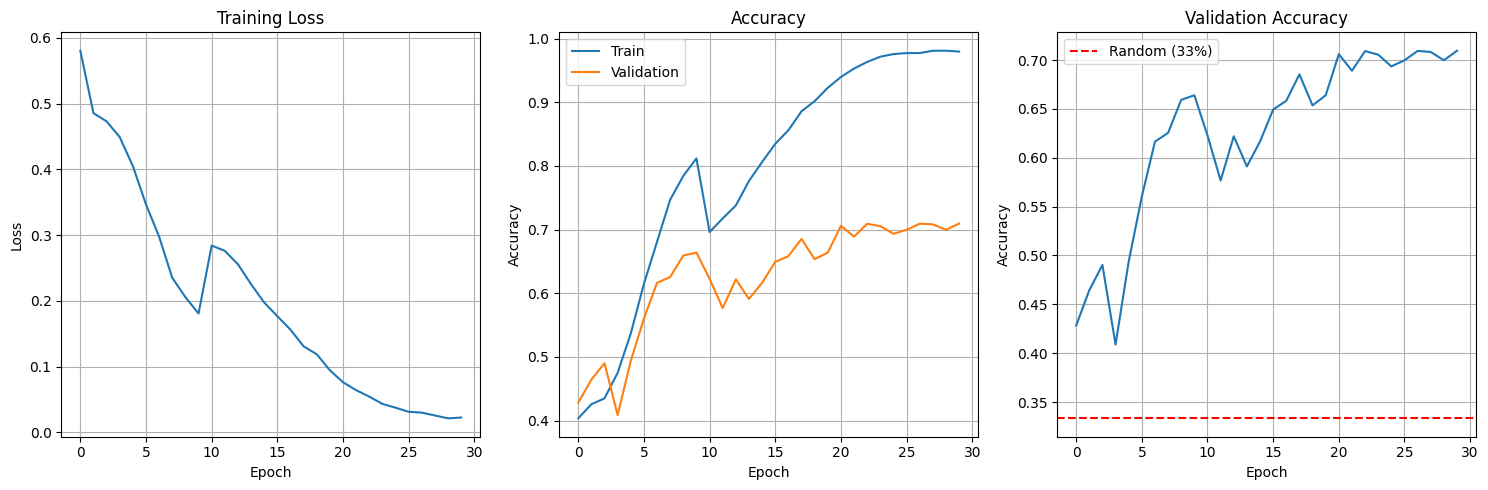


Generating confusion matrix...


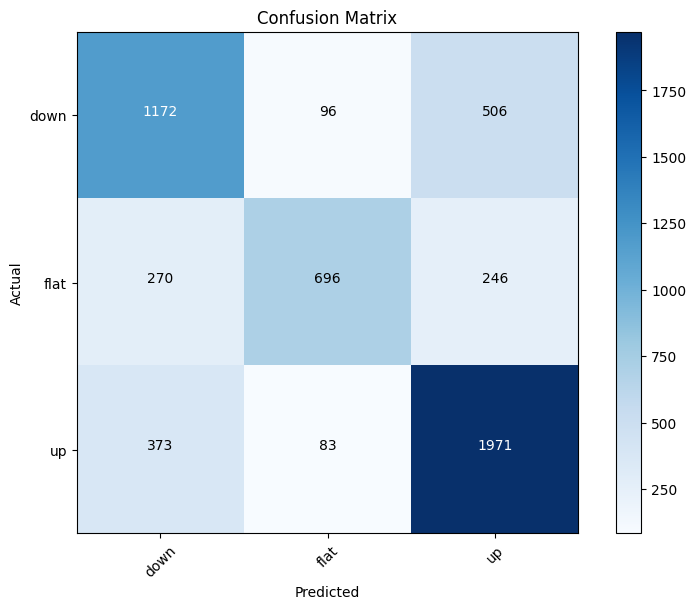


Classification Report:
              precision    recall  f1-score   support

        down       0.65      0.66      0.65      1774
        flat       0.80      0.57      0.67      1212
          up       0.72      0.81      0.77      2427

    accuracy                           0.71      5413
   macro avg       0.72      0.68      0.70      5413
weighted avg       0.71      0.71      0.71      5413


Final best validation accuracy: 0.7092


In [15]:
# Train the model
best_acc = train(
    train_loader, 
    val_loader, 
    model, 
    DEVICE, 
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    label_map=meta['label_map']
)

print(f'\nFinal best validation accuracy: {best_acc:.4f}')

In [16]:
def load_trained_model(model_path, device):
    """Load a trained model from file"""
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model architecture
    num_classes = checkpoint.get('num_classes', 3)  # Default to 3 if not saved
    model = create_model(num_classes=num_classes, device=device)
    
    # Load saved weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    # Extract metadata
    metadata = {
        'epoch': checkpoint.get('epoch'),
        'val_acc': checkpoint.get('val_acc'),
        'train_acc': checkpoint.get('train_acc'),
        'label_map': checkpoint.get('label_map'),
        'model_config': checkpoint.get('model_config', {})
    }
    
    return model, metadata

def predict_single_image(image_path, model, device, transform=None):
    """Make prediction on a single image"""
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
        ])
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return predicted_class, confidence, probabilities.squeeze().cpu().numpy()

In [17]:
import os
import json
model_path = f'{MODEL_DIR}/best_cv_model.pth'
if os.path.exists(model_path):
    loaded_model, metadata = load_trained_model(model_path, DEVICE)
    print(f"✓ Model loaded successfully!")
    print(f"  Epoch: {metadata['epoch']}")
    print(f"  Validation accuracy: {metadata['val_acc']:.4f}")
    print(f"  Label map: {metadata['label_map']}")
    
    # Test on a few validation samples
    loaded_model.eval()
    val_iter = iter(val_loader)
    test_batch, test_labels = next(val_iter)
    test_batch = test_batch.to(DEVICE)
    
    with torch.no_grad():
        outputs = loaded_model(test_batch)
        _, preds = outputs.max(1)
        
    print(f"✓ Inference test successful!")
    print(f"  Batch predictions: {preds[:5].cpu().numpy()}")
    print(f"  True labels: {test_labels[:5].cpu().numpy()}")
    
    # Save label map separately for easy access
    
    with open(f'{MODEL_DIR}/label_map.json', 'w') as f:
        json.dump(metadata['label_map'], f, indent=2)
    print(f"✓ Label map saved to {MODEL_DIR}/label_map.json")
else:
    print("❌ Model file not found. Train the model first!")

✓ Model loaded successfully!
  Epoch: 22
  Validation accuracy: 0.7092
  Label map: None
✓ Inference test successful!
  Batch predictions: [0 2 2 1]
  True labels: [0 2 2 1]
✓ Label map saved to models/label_map.json
